# Week 7 - Support Vector Machines

### Aims

By the end of this notebook you will be able to understand 

>* the Separable vs Non-separable data
>* the model refinement for SVM
>* the binary case for Default data 


1. [Setup](#setup)

2. [Separable and Non separable Data Cases](#RBH)

3. [Model refinement](#refine)

4. [Default Data for Binary Example](#default)


- In this WS we will be exploring the basics of support vector machine models. 
- SVMs have their own entire submodule of sklearn which includes more than we will be able to cover in this workshop. - We will be focusing on the most straight forward case, which is a support vector machine classifier which is provide by sklearn as the SVC model. For the details please have a look at https://scikit-learn.org/stable/modules/svm.html

NOTE THAT, for the simplicity we did not use any data partitioning in below for toy data examples. But for the real data sets, we have the data splitting procedure as a general procedure (Default data example). 

# 1. General Setup <a id='setup'></a>

## 1.1 Packages

Now lets load in the packages you wil need for this workshop.


In [50]:
# Display plots inline
%matplotlib inline  

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# sklearn modules list that might be useful, maybe you do not need to use all of them
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
import warnings # prevent warnings
import joblib # saving models
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform
import itertools
from sklearn.model_selection import GridSearchCV, KFold
#  from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For loading SVC from sklearn
from sklearn.svm import SVC

In [51]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.markersize'] = 7.5

##  1.2 Helper Functions

Below are helper functions we will be using in this workshop. You can create your own if you think it is necessary OR directly use already available helper functions within `sklearn library`.  

- `plot_margin()`: visualization of margins in figures.

You can modify the following function based on your needs as well. These practices would be important while you are working on your project either. 

In [52]:
# About visualization of margins in figures
def plot_margin(model, data, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50):
    # Plot the data
    p = sns.scatterplot(x=x, y=y, hue=cat, data=data, legend=False)
    
    # Find the extent of x and y
    xlim = p.get_xlim()
    ylim = p.get_ylim()
    
    # Create a grid of points
    xx = np.linspace(xlim[0], xlim[1], nx)
    yy = np.linspace(ylim[0], ylim[1], ny)
    YY, XX = np.meshgrid(yy, xx)
    
    # Calculate the label for each point in the grid
    xy = np.c_[XX.ravel(), YY.ravel()]
    Z = model.decision_function(xy).reshape(XX.shape)
    
    # plot contours of decision boundary and margins
    p.contour(XX, YY, Z, colors='k', 
              levels=[-1, 0, 1], alpha=0.5,
              linestyles=['--', '-', '--'])

    # highlight support vectors
    if (show_support_vectors):
        p.scatter(model.support_vectors_[:, 0], 
                  model.support_vectors_[:, 1], s=100,
                  linewidth=1, facecolors='none', edgecolors='k')

    # Show confusion table in the title
    p.set_title(
        "TN: {0}, FP: {1}, FN: {2}, TP: {3}".format(
            *confusion_matrix(
                data[cat],
                m.predict(data.drop(cat, axis=1))
            ).flatten()
        )
    )
    
    plt.show()

 **__REMARK__**

- The implementation of the SVC with sklearn requires a slightly different meaning for the parameter C. Please note that, "Regularization parameter. 
- The strength of the regularization is inversely proportional to C. Must be strictly positive." and "The C parameter trades of correct classification of training examples against maximization of the decision function's margin. 
- For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
- A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM."

### **Difference between SVC and LinearSVC**

The linear models `LinearSVC()` and `SVC(kernel='linear')` yield slightly different decision boundaries. This can be a consequence of the following differences:

>- `LinearSVC` minimizes the squared hinge loss while SVC minimizes the regular hinge loss.
>- `LinearSVC` uses the One-vs-All (also known as One-vs-Rest) multiclass reduction while `SVC` uses the One-vs-One multiclass reduction.
>- In terms of graphical display, note that unlike `SVC` (based on LIBSVM), `LinearSVC` (based on LIBLINEAR) does not provide the support vectors.

For further details, try to compare differences from their documentations

- `SVC` with `linear` kernel selection: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- `LinearSVC` function: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

# 2 Separable Data <a id='RBH'></a>

We will begin by examining several toy data problems to explore the basics of these models. To begin we will read in data for the first example from ex1.csv


In [53]:
ex1 = pd.read_csv("ex1.csv")
ex1.head()

,x,y,z
0,-0.56,-1.07,A
1,-0.23,-0.22,A
2,1.56,-1.03,A
3,0.07,-0.73,A
4,0.13,-0.63,A


We can see the that data is composed of two classes in two dimensions, and it is clear that these two classes are perfectly linearly separable

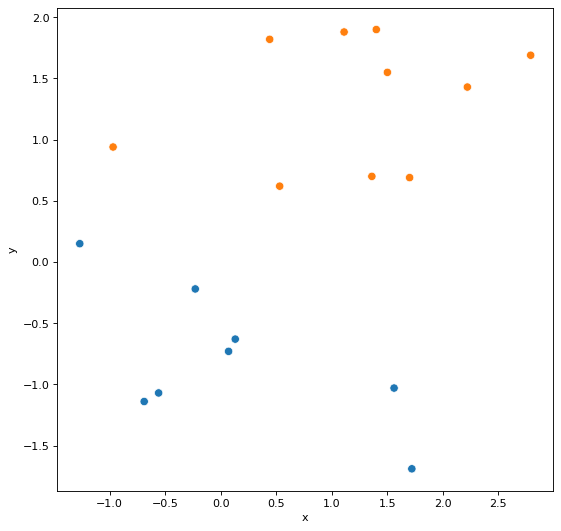

In [54]:
sns.scatterplot(x='x', y='y', hue='z', data=ex1, legend=False)
plt.show()

---

### 🚩 Exercise 1 (CORE)

Like the other models we've already seen, we fit the SVM by constructing our feature matrix and outcome vector and then calling the fit method for our model object;

1. Separate the features and outcome in the toy dataset ex1.csv
2. Fit a SVC model for this data set using `SVC()` function (Note that you need to change the default value of kernel and parameter C)
3. Visualize the decision boundary and the margins using the plot_margin function we defined above.


In [55]:
# Extracting the features and output 
X_ex1 = ex1.drop('z', axis=1)
y_ex1 = ex1.z

When fitting the model we will only worry about two parameters for now: 
- kernel which determines what if any kernel is used when calculating the dot product, 
- C which is the penalty for misclassification. 

These parameters default to kernel='rbf' for a radial basis function and C=1, we will change these to a linear kernel and a arbitrary large penalty respectively

In [1]:
# Fitting the SVC model on the data with some C value 
m = SVC(kernel='linear', C=10).fit(X_ex1, y_ex1)
m

NameError: name 'SVC' is not defined

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


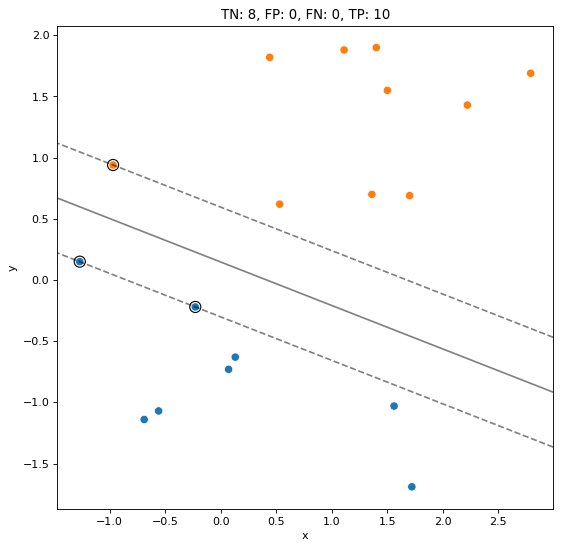

In [57]:
plot_margin(model = m, data = ex1)

### 🚩 Exercise 2  (CORE)

Based on the results of previous exercise, state that

- How many support vectors are there for this model?
- How does the boundary line and the margins change as you change the value of C?


- The solid line is the separating hyperplane (line) and the dashed lines are the margins.

- There are currently 3 support vectors - 2 blue and 1 orange

We can explore how the penalty value affects this fit by adjusting the value of C between 0 and 10 below and rerunning the cell.

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


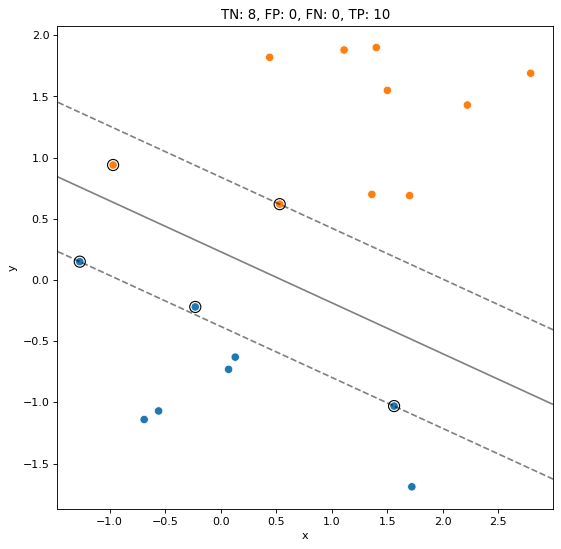

In [58]:
C = 1 # Consider some other values to explore the difference
m = SVC(kernel='linear', C=C).fit(X_ex1, y_ex1)
plot_margin(model = m, data = ex1)

# 3 Non-Separable Data

We will not complicate our previous example somewhat by adding two additional points from the blue A class to our data. This is available in the ex2.csv file.

      x     y  z
0 -0.56 -1.07  A
1 -0.23 -0.22  A
2  1.56 -1.03  A
3  0.07 -0.73  A
4  0.13 -0.63  A


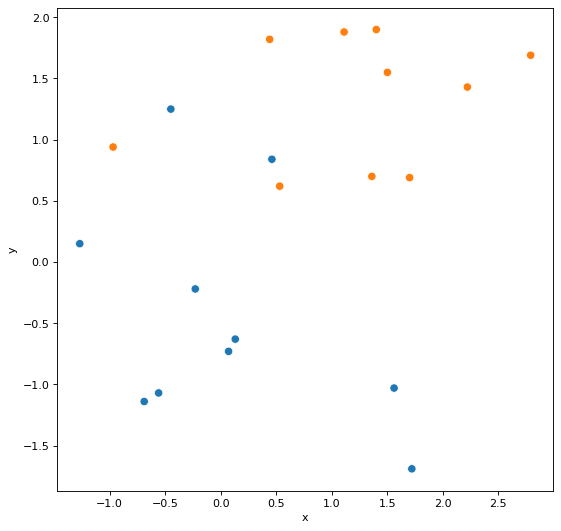

In [59]:
ex2 = pd.read_csv("ex2.csv")
print(ex2.head())

# To visualize
sns.scatterplot(x='x', y='y', hue='z', data=ex2, legend=False)
plt.show()

---

### 🚩 Exercise 3  (CORE)

- Fit a SVC model to these data using the same code we used with example 1.
- How does the "fit" of this model differ compared to the "fit" for example 1. Hint - make your comparison for equivalent values of C.
- How do the boundary line and margins change as you change the value of C?




>- Now there is no possible straight line that can be drawn that would perfectly separate these two classes.

We can again fit a SVC model to these data using the same code we used with example 1.


In [60]:
X_ex2 = ex2.drop('z', axis=1)
y_ex2 = ex2.z

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


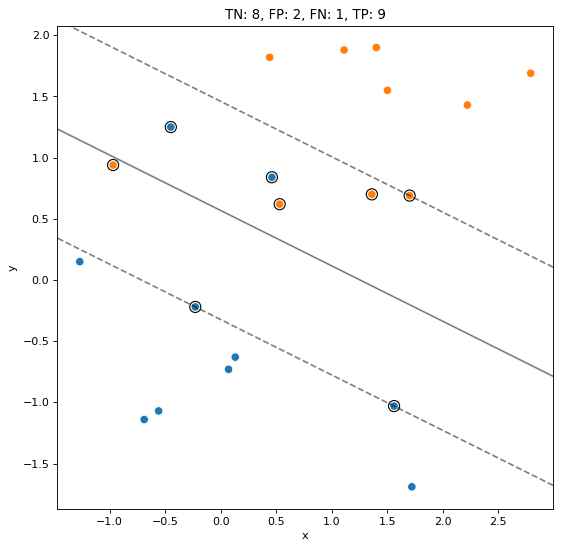

In [61]:
C = 1
m = SVC(kernel = 'linear', C = C).fit(X_ex2, y_ex2)
plot_margin(m, ex2)

- Equivalent penalty values produce larger margins with the new data at least initially. Some misclassification even for large penalties.

- As before, as C decreases the margins increase

# 4  Non-linear Case

Next we will look at a new data set that would seem to also fall in the non-separable category. The data set that we are using is ex3.csv now



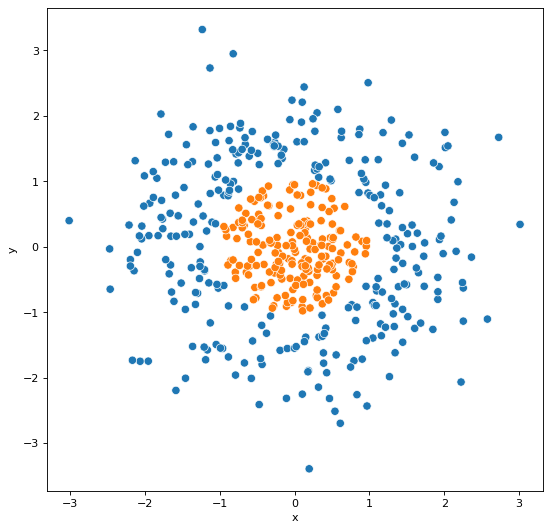

In [62]:
# For the new data set 
ex3 = pd.read_csv("ex3.csv")

# To visualize
sns.scatterplot(x='x', y='y', hue='z', data=ex3, legend=False)
plt.show()

---

### 🚩 Exercise 4  (CORE)

For this data we will consider a simple polynomial kernel with degree 2 
(choose first C = 1 ) and visualize the margins using `plot_margin()` again

More details on the various kernels that can be used with the SVC model are available 
https://scikit-learn.org/stable/modules/svm.html#svm-kernels

**The kernel function can be any of the following:**

- linear : $\langle x, x'\rangle$
- polynomial : $(\gamma \langle x, x'\rangle + r)^d$
- rbf : $\exp(-\gamma \|x-x'\|^2)$ where  $\gamma$ is specified by parameter gamma, must be greater than 0
- sigmoid : $\tanh(\gamma \langle x,x'\rangle + r)$ where $r$ is specified by `coef0`

In [63]:
X_ex3 = ex3.drop('z', axis=1)
y_ex3 = ex3.z

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


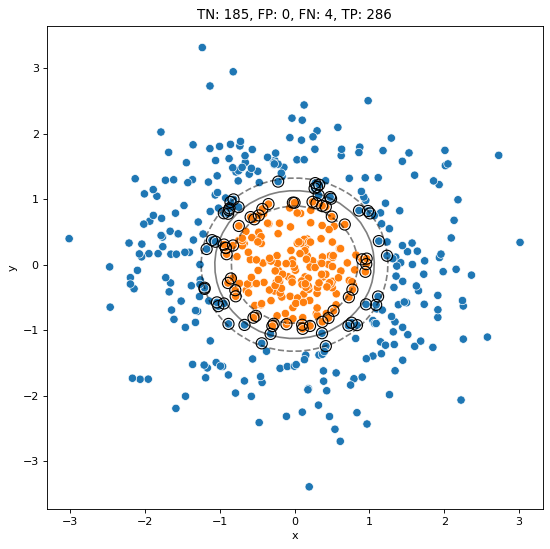

In [64]:
C = 1      # [1,2,5,7,10,20,50,100]
kernel = 'poly' # ['poly', 'linear']

m = SVC(kernel = kernel, degree = 2, C = C, gamma = 'scale').fit(X_ex3, y_ex3)
# OR 
# svc_obj = SVC(kernel=kernel, degree=2, C=C, gamma='scale')
# m = svc_obj.fit(X_ex3, y_ex3)

plot_margin(m, ex3)

---

### 🚩 Exercise 5  (CORE)

Based on the above fitted models

1. Compare the fit of the model using the polynomial and linear kernel. Describe the shape of the boundaries and the margins.

2. How do the boundary line and margins change as you change the value of C?

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


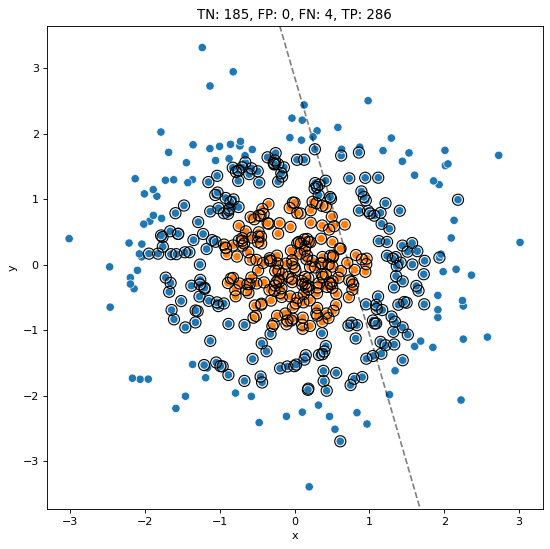

In [65]:
m_linear = SVC(kernel="linear", degree=2, C=C, gamma='scale').fit(X_ex3, y_ex3)
plot_margin(m_linear, ex3)

- The linear model does terribly separating the data, the poly d=2 model does a decent job as it produces a circular margin and boundary (which fits these data well).

- As before, as C decreases the margins increase, in this case growing outward from (0,0)

- Note that, because of the helper function `plot_margin`, you can just observe above the margin in the graph, rather than observing all graphical output (margins, hyperplane etc.)


## 4.1 Other Kernels

Next we will consider an even more complicated separation task where one class is split into two separate clusters by the second class. The data ara available as `ex4.csv`.

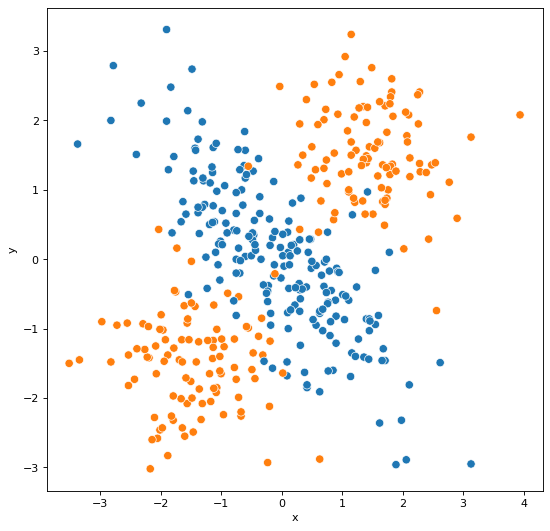

In [66]:
# For the new data set 
ex4 = pd.read_csv("ex4.csv")

# To visualize
plt.figure(figsize=(8, 8))
sns.scatterplot(x='x', y='y', hue='z', data=ex4, legend=False)
plt.show()

---
 
### 🚩 Exercise 6  (CORE)

Set up a function for experimenting with different penalties and kernel functions for this dataset (ex4.csv). For this purpose, consider, 

1. **C** in $[1,5,10,50,100]$
2. **degree** in $[2,3,4]$
3. **kernel** in $['poly', 'rbf', 'linear'])$

inside of the `SVC()` function. Note that the degree value is only used by polynomial kernel and is ignored by the linear and rbf kernels. 

In [67]:
# Extracting features and output 
X_ex4 = ex4.drop('z', axis=1)
print(X_ex4.head())
y_ex4 = ex4.z
print(y_ex4.head())

      x     y
0  0.90 -1.21
1 -1.65 -1.16
2  1.16 -1.35
3  0.76  0.39
4  1.36 -1.41
0    A
1    B
2    A
3    A
4    A
Name: z, dtype: object


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


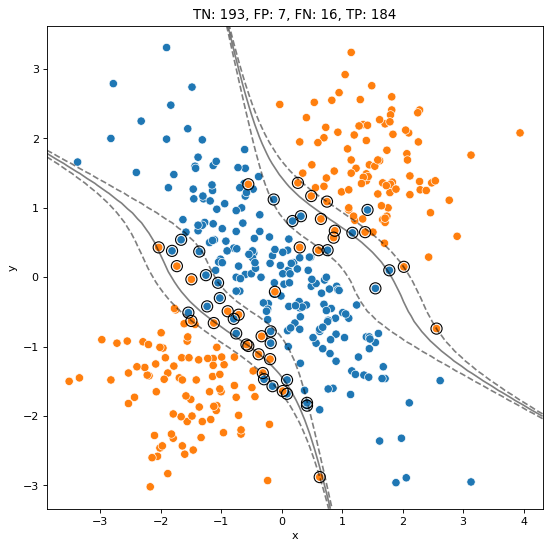

In [68]:
# For the polynomial one 

C = 50      # [1,5,10,50,100],
degree = 4  # [2,3,4],
kernel = 'poly' # ['poly', 'rbf', 'linear'])

plt.figure(figsize=(8, 8))
m = SVC(kernel=kernel, degree=degree, C=C, gamma='scale').fit(X_ex4, y_ex4)
plot_margin(m, ex4)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


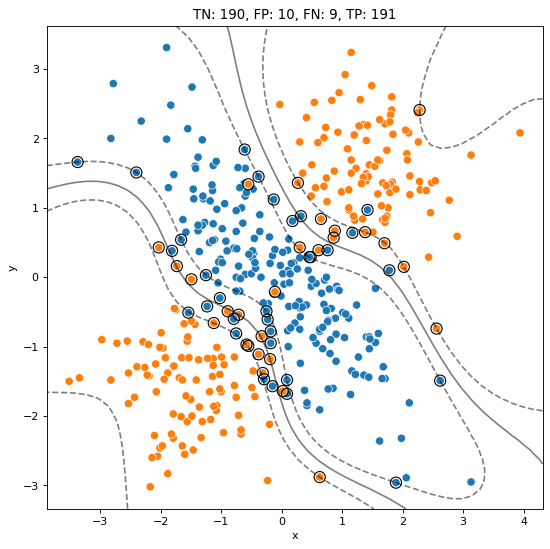

In [69]:
# As a reasonable model alternative if we look at the sum of FP and FN simply
C = 50   # [1,5,10,50,100],
degree = 4  # [2,3,4],
kernel = 'rbf' # ['poly', 'rbf', 'linear'])

plt.figure(figsize=(8, 8))
m = SVC(kernel = kernel, degree = degree, C = C, gamma = 'scale').fit(X_ex4, y_ex4)
plot_margin(m, ex4)

---

### 🚩 Exercise 7  (CORE)

Based on the above fitted models

1. What combination of parameters appears to produce the best fit? Is it easy to tell this by visual inspection alone?

2. How do the support vectors change as the kernel, penalty, and degree are changed?


>- rbf, poly d=2 and d=4 seem to do reasonably well.
>- It depends on the model, but for the better models not much - large C shrinks the margins which reduces the #.

# 5  Model Assessment <a id='refine'></a>

So far we have only inspected the various models by eye to get a sense of how well they fit our data. Since we are undertaking a classification task here we would like to be able to leverage the metrics and scoring tools we have already learned around logistic regression and related tools. The issue is that while we could generate a simple confusion matrix for our models' predictions this is somewhat limiting.

**WARNING:** 

- By default, SVM models do not support the construction of anything like a ROC curve since the predictions are not probabilistic - i.e. labels are assigned based on which side of the separator a point falls. 
- As such, SVC models do not implement predict_proba by default
- Just to recall, these are some metrics that we discussed before

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP}+ \text{FN}}
$$

$$
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$

$$
F1 = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right)
$$

---

### 🚩 Exercise 8  (CORE)

Based on the best model that you visualized above,

1. Report the accuracy of the model
2. Obtain the confusion matrix and interpret the results in terms of the quantities defined below 





In [70]:
# Let us consider the rbf model for example 4, we can fit this model and then explore what options we have.
m = SVC(kernel='rbf', C=1, gamma='scale').fit(X_ex4, y_ex4)
m.score(X_ex4, y_ex4)

0.945

In [71]:
# Confusion matrix calculation 
confmat = sklearn.metrics.confusion_matrix(y_ex4, m.predict(X_ex4))
confmat

array([[192,   8],
       [ 14, 186]])

In [72]:
# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
print(FPR)
# Recall
Recall = (TP)/(TP+FN)
print(Recall)
# Precision
Precision = (TP)/(FP+TP)
print(Precision)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)
print(F1)

0.04
0.93
0.9587628865979382
0.9441624365482233


- The obtained performance metric values are reasonably well over the whole data set. (DO NOT forget here we just used the whole data and the above calculations are valid for the whole data, not for training data here)

- We have very low FPR, high values of Recall, Precision and F1 for this classification problem


---

### 🚩 Exercise 9  (CORE)

With the available scoring metrics we can make use of the usual cross valiation tools such as cross_val_score which can be useful for the purpose of comparing different models,

1. Run the following code and get the result
2. Rearrange the ingridients of th code given below for 2-degree poylnomial kernel, compare the result with the output of 1. 
3. If you adjust $C$ are you able to find a better performing version of either the rbf or poly SVM models?



In [73]:
# Define your X_ex4 and y_ex4 based on the data set first !

rbf = sklearn.model_selection.cross_val_score(
    SVC(kernel = 'rbf', C = 1, gamma='scale'), 
    X_ex4, y_ex4, 
    cv = KFold(5, shuffle = True, random_state = 42)
)

In [74]:
print(rbf)
print(rbf.mean())

[0.975 0.925 0.95  0.95  0.925]
0.945


In [75]:
poly = sklearn.model_selection.cross_val_score(
    SVC(kernel='poly', degree = 2, C = 1, gamma ='scale'), 
    X_ex4, y_ex4, 
    cv = KFold(5, shuffle = True, random_state = 42)
)

print(poly)
print(poly.mean())

[0.975  0.8875 0.9625 0.9375 0.925 ]
0.9375


---

- Which indicates that the rbf appears to slightly outperform the degree 2 polynomial, for C=1 above.

- When you change C, the result is changing such as $C=100$, the degree 2 polynomial model outperforms the rbf case slightly.

---

### 🚩 Exercise 10  (CORE)

- Construct a full cross validated grid search over the parameter values: 

$C = np.linspace(0.1, 10, 100)$, degree = $[2,3,4]$, and kernel = $['poly', 'rbf', 'linear']$.

- Which SVM model performs best? Use plot_margin to show the resulting seperator and support vectors.

In [76]:
cv = GridSearchCV(
    SVC(),
    param_grid = { 
        'kernel':('poly', 'linear', 'rbf'), 
        'C': np.linspace(0.1, 10, 100),
        'degree': [2,3,4]
    },
    cv = KFold(5, shuffle = True, random_state = 42)
)

# Fit the model on ex4 data set
cv.fit(X_ex4, y_ex4)

# Get the best model parameters and the accuracy of the model
print("Params: ", cv.best_params_)
print("Avg Accuracy: ", cv.best_score_)

Params:  {'C': 0.7000000000000001, 'degree': 2, 'kernel': 'rbf'}
Avg Accuracy:  0.945


The best model from above search is the model with 

- C = 0.7000000000000001

- degree = 2

- kernel = "rbf"

In [78]:
#Best model from the above result
m = SVC(kernel='rbf', degree = cv.best_params_["degree"], C=cv.best_params_["C"], gamma='scale').fit(X_ex4, y_ex4)
print(m.score(X_ex4, y_ex4))

# Confusion matrix calculation 
confmat = sklearn.metrics.confusion_matrix(y_ex4, m.predict(X_ex4))
confmat

0.9425


array([[192,   8],
       [ 15, 185]])

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


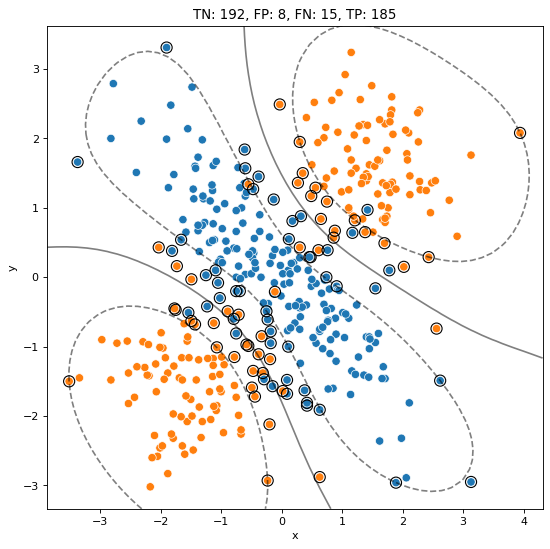

In [46]:
plot_margin(model = m, data = ex4)

# 6 Default Data Case (EXTRA) <a id='default'></a>

The dataset consists of 10000 individuals and whether their credit card has defaulted or not. Below is the column description: The main aim is to build the model using Logistic Regression and predict the accuracy of it. The included columns in the data set are as follows:

* `default` - Whether the individual has defaulted

* `student` - Whether the individual is the student

* `balance` - The balance in the individual's account

* `income` - Income of an individual

We read the data into python using pandas.


In [82]:
df_default = pd.read_csv("Default.csv", index_col=0)

# for now lets just drop the student varible.
df_default = df_default.drop("student", axis=1)
df_default.head()

,default,balance,income
1,No,729.526495,44361.62507
2,No,817.180407,12106.13470
3,No,1073.549164,31767.13895
4,No,529.250605,35704.49394
5,No,785.655883,38463.49588


---

### 🚩 Exercise 11 (EXTRA)

1. Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**) Use the test size as $10\%$ of the whole sample

2. Convert your response variable into the numerical format

3. Use the following function to get a RandomizedSearch results and sort your model results in terms of the value of "mean_test_recall". Comment on the obtained result in terms of accuracy and recall. Notice that the function uses `LinearSVC()` below but possible to write a similar oen using `SVC()` with suitable ingridients. 

Note that you can face with some warnings so try to examine those by searching the possible reasons on the use of `LinearSVC` below. 

In [83]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
data_x, data_y = df_default.drop(['default'], axis=1), df_default['default']
data_y = LE.fit_transform(data_y)

X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y, test_size = 0.1, random_state=42)

In [85]:
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr += 2

C_list

[0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048, 8192, 32768]

In [84]:
linear_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(random_state=42, max_iter=1000))
    ])

#linear_svm = Pipeline([
#        ("scaler", StandardScaler()),
#        ("svm_clf", SVC(kernel='linear', gamma='auto')) 
#    ])


# specify parameters and distributions to sample from
lin_param_dist = {'svm_clf__C':loguniform(C_list[0], C_list[-1])}

lin_rs = RandomizedSearchCV(linear_svm, lin_param_dist, n_iter=60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

lin_rs.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: Unde

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` paramet

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_clf',
                                              LinearSVC(random_state=42))]),
                   n_iter=60,
                   param_distributions={'svm_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f791ef2cf70>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [86]:
#About the summary of best 6 models 

lin_rs_df = pd.DataFrame(lin_rs.cv_results_)
lin_rs_df.sort_values("mean_test_recall", ascending=False)[[ "mean_test_accuracy", "mean_test_recall", 
                                                                  "std_test_accuracy", "std_test_recall"]].head()

,mean_test_accuracy,mean_test_recall,std_test_accuracy,std_test_recall
54,0.964556,0.421391,0.008723,0.244563
2,0.906444,0.410929,0.084265,0.399541
25,0.894778,0.373466,0.146042,0.403795
55,0.953111,0.282759,0.027540,0.316528
1,0.944222,0.258621,0.052745,0.312825


---

### 🚩 Exercise 12 (EXTRA)

Using the following code snippet, try different values of kernel and C, what seems to produce the best model? This is again written in terms of `SVC()` function for the simplicity.  

(Hint: Recommended kernels are rbf, poly, and linear).

In [87]:
# Following not needed, but makes life easier
gs_svc = sklearn.model_selection.GridSearchCV(
    make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.SVC()
    ),
    [
        {
            # Other kernels
            "svc__kernel": ["linear", "rbf"],
            "svc__C": np.logspace(-2, 2, num=10)
        },
        {
            # For polynomial part only
            "svc__kernel": ["poly"],
            "svc__degree": [1, 2, 3],
            "svc__C": np.logspace(-2, 2, num=10)
        }
    ],

    # Setting a random_state has no effect when shuffle is False. 
    # You should leave random_state to its default (None), or set shuffle=True.
    cv = sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)
).fit(X_train, y_train)

In [88]:
print( gs_svc.best_params_ )
print( gs_svc.best_score_ )

{'svc__C': 4.6415888336127775, 'svc__kernel': 'rbf'}
0.9736666666666667


If proper CV is done, we end up with an rbf model with approximate $C=4.64$ produces the best result with rbf kernel selection. The overall accuracy is presented as 0.97 up to 2 decimal places as well.

In [98]:
C = 4.64
kernel = 'rbf'

m_svc = make_pipeline(
        StandardScaler(),
        SVC(C=C, kernel=kernel)
    )

# fitted model
m_svc.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=4.64))])

In [114]:
print(m_svc.score(X_train,y_train))
print(m_svc.score(X_test,y_test))

0.9676666666666667
0.958


In [123]:
# Confusion matrix calculation on test data 
confmat = confusion_matrix(y_train, m_svc.predict(X_train))
confmat

array([[8709,    0],
       [ 291,    0]])

In [124]:
# Confusion matrix calculation on test data 
confmat = confusion_matrix(y_test, m_svc.predict(X_test))
confmat

array([[958,   0],
       [ 42,   0]])

---

### 🚩 Exercise 13 (EXTRA)

Comment out the line of code that includes the `StandardScaler` in the pipeline below. 

- What happens to the models predictive performance? 

- Try adjusting C and or kernel manually to see if you can improve the performance

In [125]:
C = 4.64
kernel = 'rbf'

m_svc = make_pipeline(
        #StandardScaler(),
        SVC(C=C, kernel=kernel)
    )

# fitted model
m_svc.fit(X_train,y_train)

Pipeline(steps=[('svc', SVC(C=4.64))])

In [126]:
print(m_svc.score(X_train, y_train))
print(m_svc.score(X_test, y_test))

0.9676666666666667
0.958


In [127]:
# Confusion matrix calculation on test data 
confmat = confusion_matrix(y_train, m_svc.predict(X_train))
confmat

array([[8709,    0],
       [ 291,    0]])

In [128]:
# Confusion matrix calculation on test data 
confmat = confusion_matrix(y_test, m_svc.predict(X_test))
confmat

array([[958,   0],
       [ 42,   0]])

- When the Scaling is cancelled, there is a reduction for both training and testing data performance regarding the accuracy

- Nothing really changed on the confusion matrix values !

---

### 🚩 Exercise 14 (EXTRA)

Using the following lines of codes to try different values of C to tune the model, how does its performance compare to the `SVC` model result ?

In [129]:
C = 4.64

m_lsvc = make_pipeline(
        StandardScaler(),
        LinearSVC(C = C, max_iter = 5000)
    )

m_lsvc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=4.64, max_iter=5000))])

In [130]:
print(m_lsvc.score(X_train, y_train))
print(m_lsvc.score(X_test, y_test))

0.9725555555555555
0.961


In [132]:
# Confusion matrix calculation on test data 
confmat = confusion_matrix(y_train, m_lsvc.predict(X_train))
confmat

array([[8698,   11],
       [ 236,   55]])

In [133]:
# Confusion matrix calculation on test data 
confmat = confusion_matrix(y_test, m_lsvc.predict(X_test))
confmat

array([[955,   3],
       [ 36,   6]])

>- Simply the obtained train and test data performance similar to the output of SVC above when we used the same C value
>- For different values of C, we observed slight differences on the accuracy value here
>- The values in the confusion matrix is a bit different what we observed in the output of `SVC()` function above